## Preliminary step: Install and Import Libraries.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import IPython.display as ipd
import torch
import torchaudio
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import librosa
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio
import norbert
import shutil

## Loading of the Model and Device Selection

In [3]:
bundle = torchaudio.pipelines.HDEMUCS_HIGH_MUSDB_PLUS
model = bundle.get_model()
sample_rate = bundle.sample_rate

cpu_device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # windows
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # macOS
model.to(device)

HDemucs(
  (freq_encoder): ModuleList(
    (0): _HEncLayer(
      (conv): Conv2d(4, 48, kernel_size=(8, 1), stride=(4, 1), padding=(2, 0))
      (norm1): Identity()
      (rewrite): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      (norm2): Identity()
      (dconv): _DConv(
        (layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
            (4): GroupNorm(1, 96, eps=1e-05, affine=True)
            (5): GLU(dim=1)
            (6): _LayerScale()
          )
          (1): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
           

Device Check:

In [4]:
device

device(type='mps')

## Loading of the Dataset and Dataset Preparation

Download the dataset at: https://zenodo.org/records/3338373

Global variables:

In [6]:
SEGMENT_LENGTH = 30  # 30 seconds of audio from each song
DATASET_FOLDER =  "./musdb18hq/test" # dataset should be inside the project folder
DATASET_FOLDER_TRIMMED = "./musdb18hq_trimmed" # trimmed dataset will be saved here

Dictionary creation

(Dataset Structure: `{track_folder -> {stem_name -> waveform}`)


In [7]:
def get_max_non_silence_start(song):
    """
    Given a song (dictionary of stem names -> waveform),
    use librosa.effects.trim to find the starting index of non-silent 
    segments for each stem and return the highest start index.
    """
    max_start = 0
    for stem, waveform in song.items():
        # Convert tensor waveform to numpy if necessary
        if hasattr(waveform, "detach"):
            waveform_np = waveform.detach().cpu().numpy()
        else:
            waveform_np = waveform
        
        # If waveform is multi-channel (shape: channels x samples)
        if waveform_np.ndim > 1:
            # Convert to mono using librosa.to_mono
            waveform_np = librosa.to_mono(waveform_np)
        else:
            waveform_np = waveform_np.squeeze()

        # Trim leading and trailing silence
        # trim returns a tuple (trimmed_audio, (start, end))
        trimmed, indices = librosa.effects.trim(waveform_np)
        if indices.size and indices[0] > max_start:
            max_start = indices[0]
            
    return max_start
def is_stem_silent(waveform, threshold=1e-4):
    """
    Determines if a given song stem is not silent.
    
    Args:
        waveform (torch.Tensor or np.ndarray): The audio waveform of the stem.
        threshold (float): The amplitude threshold below which the stem is considered silent.
    
    Returns:
        bool: True if the stem is not silent, False otherwise.
    """
    # Convert tensor waveform to numpy if necessary
    if hasattr(waveform, "detach"):
        waveform = waveform.detach().cpu().numpy()
    
    # If waveform is multi-channel (shape: channels x samples), convert to mono
    if waveform.ndim > 1:
        waveform = librosa.to_mono(waveform)
    
    # Check if the maximum absolute amplitude exceeds the threshold
    return np.max(np.abs(waveform)) < threshold
def load_and_process_dataset():
    """
    Load the dataset from the specified folder.
    Each subfolder in the dataset corresponds to a song.
    Each song contains multiple stems (e.g., mixture, drums, bass, etc.).
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """

    # sorted list of folders in the dataset
    track_folders = sorted(
        folder for folder in os.listdir(DATASET_FOLDER)
        if os.path.isdir(os.path.join(DATASET_FOLDER, folder))
    )

    # Dictionary to store {track_folder -> {stem_name -> waveform}}
    dataset_dict = {}

    # Each subfolder in musdb18hq/test corresponds to a song
    for track_folder in tqdm(track_folders):
        track_path = os.path.join(DATASET_FOLDER, track_folder)
        if not os.path.isdir(track_path):
            continue

        # Prepare a sub-dictionary for this song
        stems_dict = {}
        stem_names = ["mixture", "drums", "bass", "vocals", "other"]
        
        for stem_name in stem_names:
            file_path = os.path.abspath(os.path.join(track_path, f"{stem_name}.wav"))
            
            if not os.path.isfile(file_path):
                print(f"Warning: file not found {file_path}")
                continue

            # Load full audio
            # print(f"Loading {track_folder}" + f" - {stem_name}")
            waveform, sr = torchaudio.load(file_path)

            stems_dict[stem_name] = waveform
        
        max_start = get_max_non_silence_start(stems_dict)

        # If the stem is silent, remove it from the dictionary else trim it
        for stem_name, waveform in stems_dict.items():
            if is_stem_silent(waveform) or waveform.shape[1] < SEGMENT_LENGTH * sample_rate + max_start:
                print(f"Removing silent stem: {stem_name}")
                del stems_dict[stem_name]
            else:
                # Trim the waveform to the max_start to segment samples
                duration = SEGMENT_LENGTH * sample_rate + max_start
                stems_dict[stem_name] = waveform[:, max_start:duration]

        dataset_dict[track_folder] = stems_dict

    return dataset_dict


def load_dataset():
    """
    Load the dataset from the DATASET_FOLDER_TRIMMED folder.
    Each subfolder in the dataset corresponds to a song.
    Each song contains multiple stems (e.g., mixture, drums, bass, etc.).
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """
    dataset_dict = {}

    for track_folder in tqdm(os.listdir(DATASET_FOLDER_TRIMMED)):
        track_path = os.path.join(DATASET_FOLDER_TRIMMED, track_folder)
        if not os.path.isdir(track_path):
            continue

        # Prepare a sub-dictionary for this song
        stems_dict = {}
        
        for stem_name in ["mixture", "drums", "bass", "vocals", "other", "new_mixture"]:
            file_path = os.path.abspath(os.path.join(track_path, f"{stem_name}.wav"))
            
            if not os.path.isfile(file_path):
                print(f"Warning: file not found {file_path}")
                continue

            # Load full audio
            waveform, sr = torchaudio.load(file_path)

            stems_dict[stem_name] = waveform
            
        dataset_dict[track_folder] = stems_dict
        
    return dataset_dict

def create_dataset(dataset_dict):
    """
    Create a dataset of trimmed audio files from the musdb18hq dataset.
    The dataset is saved in the DATASET_FOLDER_TRIMMED folder.
    It processes each track folder, saves the stems as individual files,
    and generates a new_mixture file as the sum of the stems.
    Args:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    Returns:
        None
    """
    for track_folder, stems_dict in tqdm(dataset_dict.items()):
    
        track_path = os.path.join(DATASET_FOLDER_TRIMMED, track_folder)
        os.makedirs(track_path, exist_ok=True)
        
        # Add new_mixture file to the track folder as the sum of the stems
        new_mixture = torch.zeros((2, SEGMENT_LENGTH * sample_rate))
        for stem_name, waveform in stems_dict.items():
            
            file_path = os.path.join(track_path, f"{stem_name}.wav")
            torchaudio.save(file_path, waveform, sample_rate=sample_rate)

            # Generation of the new_mixture file
            if stem_name != "mixture":
                new_mixture += waveform

        # make the new_mixture the same loudness as the original mixture
        if "mixture" in stems_dict:
            original_mixture = stems_dict["mixture"]

            # Scale the new mixture to match the volume of the original mixture
            original_max_value = torch.max(torch.abs(original_mixture))
            new_max_value = torch.max(torch.abs(new_mixture))
            if new_max_value > 0:
                new_mixture *= (original_max_value / new_max_value)
        else:
            # If there is no original mixture, just normalize the new_mixture
            new_mixture = new_mixture / torch.max(torch.abs(new_mixture))


        # Raise an error if the new_mixture is not normalized
        if torch.max(torch.abs(new_mixture)) > 1:
            # delete dataset folder if error occurs
            if os.path.isdir(DATASET_FOLDER_TRIMMED):
                print(f"Deleting dataset folder {DATASET_FOLDER_TRIMMED} due to error.")
                shutil.rmtree(DATASET_FOLDER_TRIMMED)

            raise ValueError(f"new_mixture for {track_folder} is not normalized. Max value: {torch.max(torch.abs(new_mixture))}")
        
        
        # Trim the new_mixture to the desired length
        new_mixture = new_mixture[:, :SEGMENT_LENGTH * sample_rate]
        new_mixture_path = os.path.join(track_path, "new_mixture.wav")
        torchaudio.save(new_mixture_path, new_mixture, sample_rate)
        #print(f"Saved new mixture to {new_mixture_path}")
        
        # Add the new_mixture to stems_dict and update dataset_dict
        stems_dict["new_mixture"] = new_mixture
        dataset_dict[track_folder] = stems_dict  # Update the dataset_dict explicitly
        #print(f"Added new_mixture to stems_dict for track {track_folder}")


def load_or_create_trimmed_dataset():
    """
    Load or create the trimmed dataset.
    If the dataset already exists, it loads the dataset from the musdb18hq_trimmed folder.
    If the dataset does not exist, it processes the musdb18hq/test folder and saves the trimmed dataset.
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """
    # Check if the trimmed dataset already exists
    if os.path.isdir(DATASET_FOLDER_TRIMMED):
        print("Dataset already exists.")

        # Load the trimmed dataset
        dataset_dict = load_dataset()
        print("Dataset loaded.")
    else:
        print("Loading dataset...")
        dataset_dict = load_and_process_dataset()
        print("Dataset loaded.")
    
        # Save the trimmed dataset
        os.makedirs(DATASET_FOLDER_TRIMMED, exist_ok=True)
        create_dataset(dataset_dict)

        print("Trimmed dataset saved.")
    
    return dataset_dict

Save the new DATASET FOLDER

In [8]:
dataset_dict = load_or_create_trimmed_dataset()

Loading dataset...


100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


Dataset loaded.


100%|██████████| 50/50 [00:02<00:00, 22.15it/s]

Trimmed dataset saved.


Trimmed tracks check

In [9]:
print("Number of keys in dataset_dict:", len(dataset_dict))

# Check the first track folder and its contents
first_track_folder = list(dataset_dict.keys())[0]
print("First track folder:", first_track_folder)
print("Contents of the first track folder:")
def print_stem_shapes(first_track_folder):
    for stem_name in dataset_dict[first_track_folder].keys():
        print(f" - {stem_name}: {dataset_dict[first_track_folder][stem_name].shape}")

print_stem_shapes(first_track_folder)


Number of keys in dataset_dict: 50
First track folder: AM Contra - Heart Peripheral
Contents of the first track folder:
 - mixture: torch.Size([2, 1323000])
 - drums: torch.Size([2, 1323000])
 - bass: torch.Size([2, 1323000])
 - vocals: torch.Size([2, 1323000])
 - other: torch.Size([2, 1323000])
 - new_mixture: torch.Size([2, 1323000])


Function to separate the sources


In [10]:
def separate_sources(
    model,
    mix,
    sample_rate=sample_rate,
    overlap=0.0,  # set to 0.0 to avoid chunk repetition
    device=None,
    normalize=False,
):
    """
    Separate sources from a mixture using the provided model.
    Args:
        model: The separation model.
        mix: The input mixture tensor (batch, channels, length).
        sample_rate: Sample rate of the audio.
        overlap: Overlap between segments in seconds.
        device: Device to run the model on (CPU or GPU).
        normalize: Whether to normalize the input mixture.
    Returns:
        final: The separated sources tensor (batch, sources[drums, bass, other, vocel], channels, length). #CORRECT ORDER UPDATED
    """

    if device is None:
        device = mix.device
    else:
        device = torch.device(device)

    batch, channels, length = mix.shape

    # normalize the input by its RMS
    if normalize:
        # mix = mix / torch.sqrt(torch.mean(mix ** 2, dim=-1, keepdim=True))
        mix = mix / torch.max(torch.abs(mix))

    # chunk_len for entire 30s, no overlap
    chunk_len = int(mix.shape[2] * (1 + overlap))  # effectively 30s if overlap=0
    start = 0
    end = chunk_len

    overlap_frames = int(overlap * sample_rate)
    fade = torchaudio.transforms.Fade(fade_in_len=0, fade_out_len=overlap_frames, fade_shape="linear")

    # Prepare final buffer
    final = torch.zeros(batch, len(model.sources), channels, length, device=device)

    while start < length - overlap_frames:
        chunk = mix[:, :, start:end]
        with torch.no_grad():
            out = model(chunk).to(device)
            
        out = fade(out)
        final[:, :, :, start:end] += out

        if start == 0:
            fade.fade_in_len = overlap_frames
            start += chunk_len - overlap_frames
        else:
            start += chunk_len
        end += chunk_len
        if end >= length:
            fade.fade_out_len = 0

    return final

Evaluation of the results

In [11]:
def evaluate_sdr(original_stem: torch.Tensor, predicted_stem: torch.Tensor, device: torch.device=None):
    """
    Calculate the Scale-Invariant Signal-to-Distortion Ratio (SDR) between the original and predicted stems.

    Args:
        original_stem (torch.Tensor): The original stem waveform (shape: [channels, samples]).
        predicted_stem (torch.Tensor): The predicted stem waveform (shape: [channels, samples]).

    Returns:
        float: The SDR value.
    """
    # Ensure both tensors are on the same device
    original_stem.to(device)
    predicted_stem.to(device)
    
    # Initialize the SDR metric
    sdr_metric = ScaleInvariantSignalDistortionRatio().to(device)

    # Compute the SDR
    sdr_value = sdr_metric(predicted_stem, original_stem).item()

    return sdr_value

Evaluation of the model in standard usage

<b> `compute_sdrs` </b>
This function computes the Scale-Invariant Signal-to-Distortion Ratio (SDR) for each stem. It compares the original stems from `stems_dict` with the predicted stems from `separated_sources` using the `evaluate_sdr` function. The SDR values are stored in a dictionary (`sdr_results`) with stem names as keys.

In [12]:
def compute_sdrs(model, device, stems_dict, separated_sources):
    """Compute SDRs for each stem."""
    sdr_results = {stem: [] for stem in model.sources}
    for i, stem_name in enumerate(model.sources):
        # test normalization
        original_stem = stems_dict[stem_name].to(device)
        predicted_stem = separated_sources[0, i].to(device)
        sdr_value = evaluate_sdr(original_stem, predicted_stem, device=device)
        sdr_results[stem_name].append(sdr_value)

    return sdr_results

In [13]:
def compute_beta_sdrs(model, device, stems_dict, separated_sources, target_stem, beta):
    """Compute SDRs for each stem."""
    sdr_results_beta = {stem: [] for stem in model.sources}
    for i, stem_name in enumerate(model.sources):
        if stem_name != target_stem:
            predicted_stem_beta_mod = separated_sources[0, i].to(device) / (1 - beta)
        else:
            predicted_stem_beta_mod = separated_sources[0, i].to(device)
        
        original_stem = stems_dict[stem_name].to(device)
        sdr_value_beta = evaluate_sdr(original_stem, predicted_stem_beta_mod, device=device)
        sdr_results_beta[stem_name].append(sdr_value_beta)

    return sdr_results_beta

In [14]:
def evaluate_sdr_across_dataset(dataset_dict, model, sample_rate, device, normalize, verbose=False):
    """
    Evaluate the SDR for each track in the dataset.
    Args:
        dataset_dict (dict): Dictionary containing the dataset.
        model: The separation model.
        sample_rate: Sample rate of the audio.
        device: Device to run the model on (CPU or GPU).
        normalize: Whether to normalize the input mixture.
        verbose (bool): Whether to print detailed logs.
    Returns:
        average_sdr (dict): Dictionary containing the average SDR for each stem.
    """
    sdr_results = {stem: [] for stem in ["bass", "drums", "vocals", "other"]}

    sdr_results_list = []

    for track_name, stems_dict in tqdm(dataset_dict.items()):
        if verbose:
            print(f"Processing track: {track_name}")

        # Ensure the mixture exists in the stems
        if "new_mixture" not in stems_dict:
            if verbose:
                print(f"Skipping track {track_name} as it does not contain a new mixture.")
            continue

        # Load the mixture and move it to the correct device
        mixture = stems_dict["new_mixture"].to(device).unsqueeze(0)  # Add batch dimension
        
        # Perform source separation
        separated_sources = separate_sources(model, mixture, sample_rate=sample_rate, device=device, normalize=normalize)

        # Evaluate SDR for each stem
        sdr_results = compute_sdrs(model, device, stems_dict, separated_sources)

        # Convert sdr_results to a tensor for this track
        sdr_tensor = torch.tensor([sdr_results[stem][0] for stem in model.sources])
        
        # Append the SDR tensor to the collection
        sdr_results_list.append(sdr_tensor)

    # Calculate the average and standard deviation SDR for each stem
    if sdr_results_list:
        sdr_collection = torch.stack(sdr_results_list)
        average_sdr = {stem: torch.mean(sdr_collection[:, i]).item() for i, stem in enumerate(model.sources)}
        std_sdr = {stem: torch.std(sdr_collection[:, i]).item() for i, stem in enumerate(model.sources)}
    else:
        average_sdr = {stem: None for stem in model.sources}
        std_sdr = {stem: None for stem in model.sources}

    if verbose:
        print("\nAverage SDR for each stem:")
        for stem, avg_sdr in average_sdr.items():
            print(f"{stem}: {avg_sdr:.2f} dB" if avg_sdr is not None else f"{stem}: No data")
        print("\nStandard Deviation of SDR for each stem:")
        for stem, std in std_sdr.items():
            print(f"{stem}: {std:.2f} dB" if std is not None else f"{stem}: No data")

    return sdr_collection

In [15]:
# Evaluate SDR across the dataset using the provided function using no normalization.
sdr_collection = evaluate_sdr_across_dataset(dataset_dict, model, sample_rate, device, normalize=False)

100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


In [16]:
def plot_sdr_results(sdr_collection, model):
    """
    Create a box plot for the SDR results for each stem using raw data.

    Args:
        sdr_collection (torch.Tensor): Tensor containing all SDR results [n_samples, n_stems].
        model: Model object containing the sources list.
    """
    stems = model.sources
    
    plt.figure(figsize=(10, 6))

    plt.rcParams.update({'font.size': 16})  # Sets default font size for all elements
    
    # Extract data for each stem
    box_data = [sdr_collection[:, i].numpy() for i in range(len(stems))]
    
    box_plot = plt.boxplot(box_data, labels=stems, patch_artist=True, showfliers=False, orientation="horizontal", notch=True)
    
    # Color the boxes
    colors = ['blue', 'orange', 'green', 'red']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    plt.xlabel('SDR (dB)')
    plt.ylabel('Stem')
    plt.grid(axis='x', alpha=0.3)
    plt.show()

/var/folders/b3/9p1vx9h57c39zzmtx2ds2ffw0000gn/T/ipykernel_84019/3312871678.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(box_data, labels=stems, patch_artist=True, showfliers=False, orientation="horizontal", notch=True)


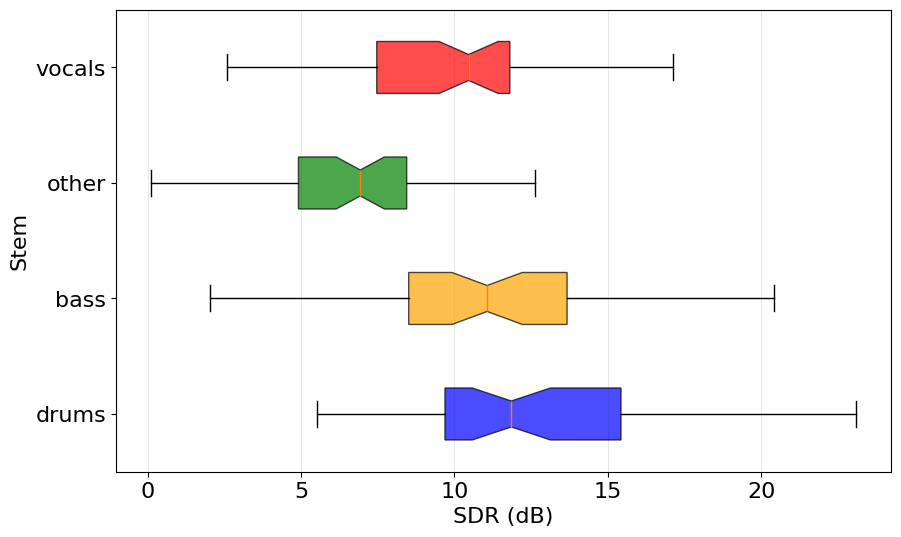

In [17]:
plot_sdr_results(sdr_collection, model)